In [47]:
import numpy as np
import pandas as pd
import os

from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(16,8)})

In [48]:
data_path = '../../../data/train_data/host'
dfs = {}
for file in os.listdir(data_path):
    print('Reading ' + file)
    dfs[file[:-4]] = pd.read_csv(data_path+'/'+file) 

Reading dcos_docker.csv
Reading os_linux.csv
Reading db_oracle_11g.csv
Reading mw_redis.csv
Reading dcos_container.csv


In [49]:
dfs['dcos_docker'].head()

,itemid,name,bomc_id,timestamp,value,cmdb_id
0,999999996381324,container_session_used,ZJ-004-058,1588521611000,0.0,docker_008
1,999999996381333,container_fgct,ZJ-004-104,1588521611000,0.0,docker_008
2,999999996381334,container_cpu_used,ZJ-004-059,1588521611000,0.0,docker_008
3,999999996381323,container_thread_idle,ZJ-004-063,1588521611000,0.0,docker_008
4,999999996381322,container_thread_running,ZJ-004-062,1588521611000,0.0,docker_008


In [50]:
def normalise(df):
    mean = df['value'].mean()
    std = df['value'].std()
    df['value'] = (df['value'] - training_mean) / training_std
    return df

def gen_train_seq(values):
    TIME_STEPS = 288

    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
        
    return np.stack(output)



In [51]:
for key in dfs:
    print('*'*40)
    print(key)
    df = dfs[key]
    for name in list(df_c.name.unique()):
        df_train = df_c[df_c.name==name]
        print(df_train.head())

        for cmdb_id in list(df.cmdb_id.unique()):
            df_c = df[df.cmdb_id == cmdb_id]
            df_c = df_c.set_index('timestamp')[['value']]
            df_c = normalise(df_c)
            
        

****************************************
dcos_docker


AttributeError: 'DataFrame' object has no attribute 'name'

In [52]:
df_train = dfs['dcos_docker'][dfs['dcos_docker'].cmdb_id == 'docker_003'][dfs['dcos_docker'].name=='container_cpu_used']
df_train = df_train.set_index('timestamp')[['value']]

<ipython-input-52-285821730d80>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train = dfs['dcos_docker'][dfs['dcos_docker'].cmdb_id == 'docker_003'][dfs['dcos_docker'].name=='container_cpu_used']


In [65]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_train.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (1092, 288, 1)


In [66]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 144, 32)           256       
_________________________________________________________________
dropout_12 (Dropout)         (None, 144, 32)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose_18 (Conv1DT (None, 144, 16)           1808      
_________________________________________________________________
dropout_13 (Dropout)         (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_19 (Conv1DT (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_20 (Conv1DT (None, 288, 1)           

In [67]:
history = model.fit(
    x_train,
    x_train,
    epochs=60,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/60
8/8 [==============================] - 0s 38ms/step - loss: 1907.7043 - val_loss: 1328.3751
Epoch 2/60
8/8 [==============================] - 0s 25ms/step - loss: 1024.4976 - val_loss: 593.9512
Epoch 3/60
8/8 [==============================] - 0s 24ms/step - loss: 615.6104 - val_loss: 546.8473
Epoch 4/60
8/8 [==============================] - 0s 25ms/step - loss: 530.2645 - val_loss: 546.8585
Epoch 5/60
8/8 [==============================] - 0s 24ms/step - loss: 485.3784 - val_loss: 500.8327
Epoch 6/60
8/8 [==============================] - 0s 23ms/step - loss: 460.6925 - val_loss: 497.8045
Epoch 7/60
8/8 [==============================] - 0s 25ms/step - loss: 442.6955 - val_loss: 461.8178
Epoch 8/60
8/8 [==============================] - 0s 26ms/step - loss: 421.3990 - val_loss: 441.3612
Epoch 9/60
8/8 [==============================] - 0s 31ms/step - loss: 396.0417 - val_loss: 395.6415
Epoch 10/60
8/8 [==============================] - 0s 28ms/step - loss: 365.8673 - val_l

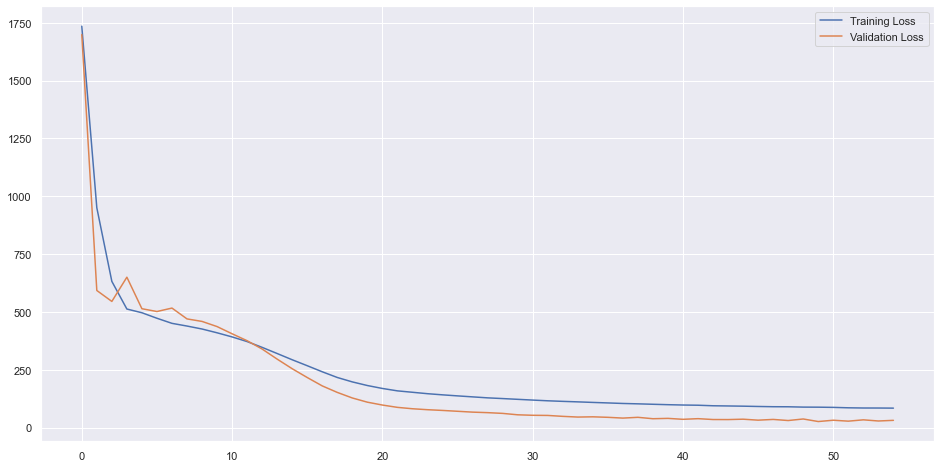

In [62]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

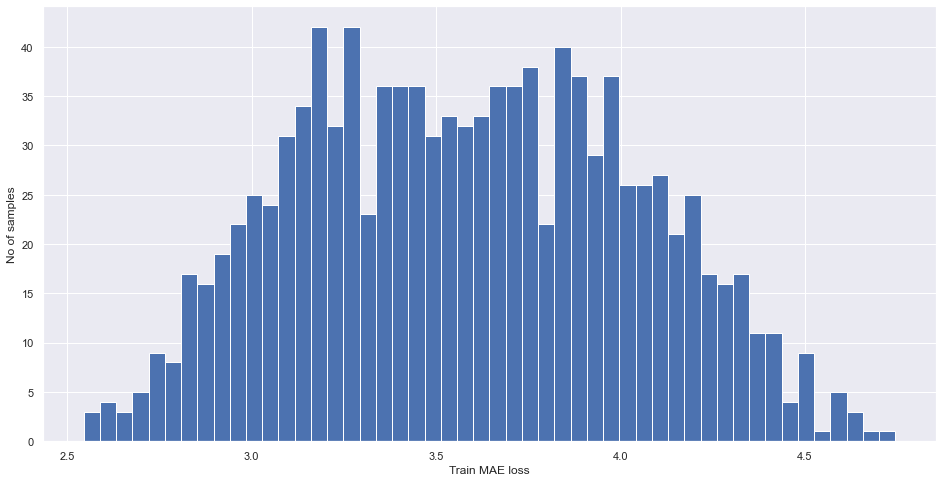

Reconstruction error threshold:  4.744756506548987


In [68]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

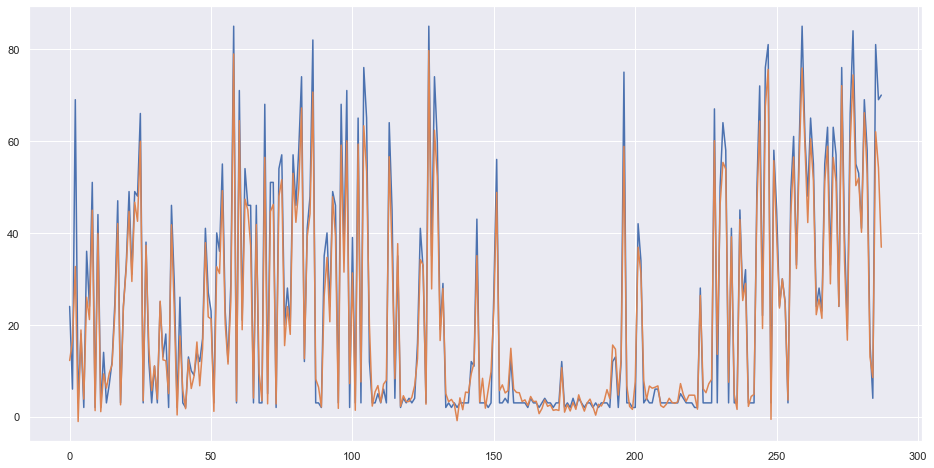

In [69]:
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

In [37]:
data_path = '../../../data/test_data/host'
dfs_test = {}
for file in os.listdir(data_path):
    print('Reading ' + file)
    dfs_test[file[:-4]] = pd.read_csv(data_path+'/'+file) 

Reading os.csv
Reading db.csv
Reading redis.csv
Reading container.csv
Reading docker.csv


<ipython-input-38-0291cb22a892>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test = dfs_test['docker'][dfs_test['docker'].cmdb_id == 'docker_003'][dfs_test['docker'].name=='container_cpu_used']


<AxesSubplot:xlabel='timestamp', ylabel='value'>

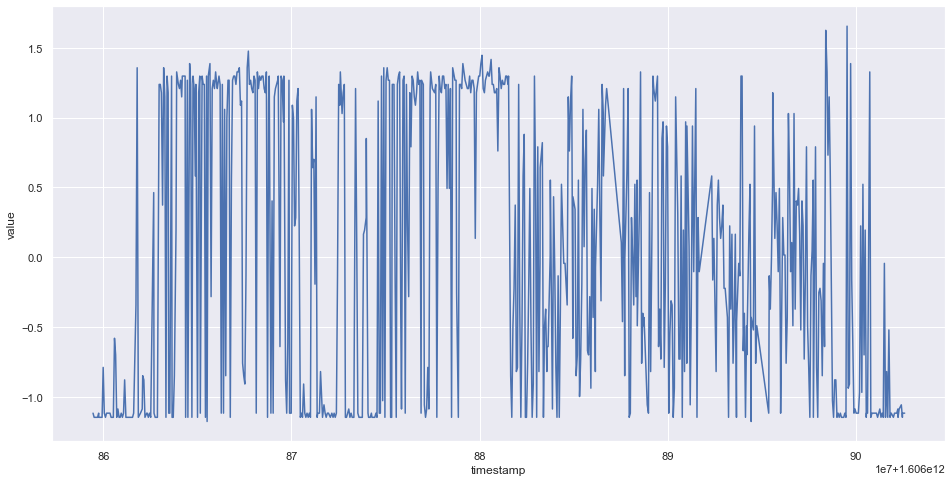

In [38]:
df_test = dfs_test['docker'][dfs_test['docker'].cmdb_id == 'docker_003'][dfs_test['docker'].name=='container_cpu_used']
df_test = df_test.set_index('timestamp')[['value']]
training_mean = df_test['value'].mean()
training_std = df_test['value'].std()
df_test['value'] = (df_test['value'] - training_mean) / training_std

sns.lineplot(x='timestamp', y='value', data=df_test)


In [41]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_test = create_sequences(df_test.values)
print("Training input shape: ", x_test.shape)

Training input shape:  (393, 288, 1)


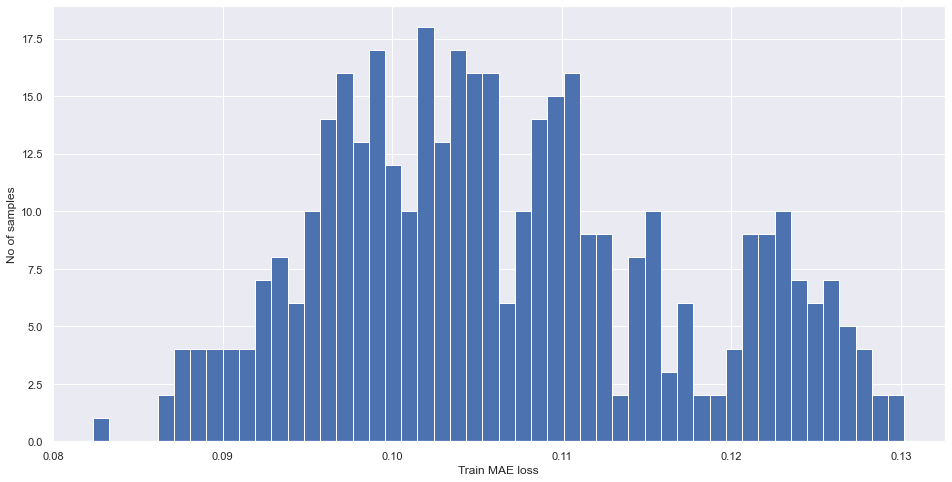

Reconstruction error threshold:  0.1302063296106185


In [42]:
# Get train MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(test_mae_loss)
print("Reconstruction error threshold: ", threshold)

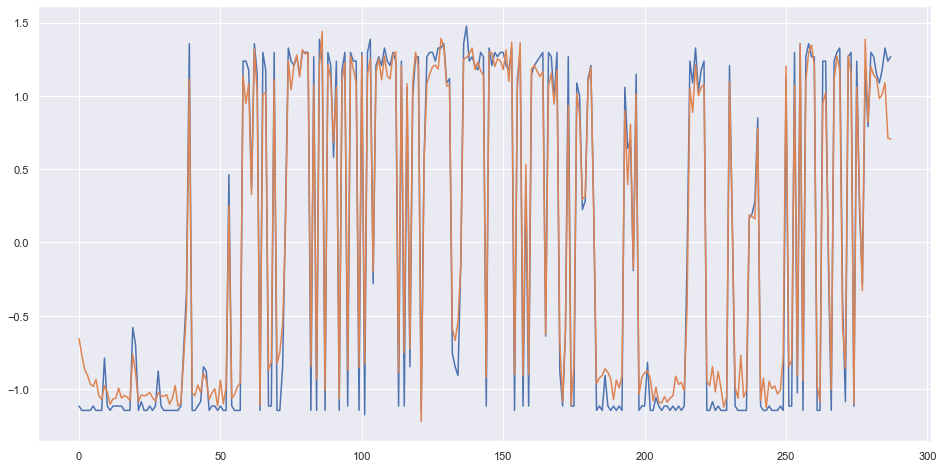

In [43]:
plt.plot(x_test[0])
plt.plot(x_test_pred[0])
plt.show()

1360